## Step one: load map image

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from yaml import load, dump
import skimage
import os

MAPS_DIR = 'maps'

map_name = 'mieszkanie_d03'
with open(os.path.join(MAPS_DIR, map_name+'.yaml'), 'r') as f:
    map_meta = load(f)

print(map_meta)
map_img = mpimg.imread(os.path.join(MAPS_DIR, map_meta['image']))
print(map_img.shape)

if map_meta['negate']:
    p = map_img / 255.0
else:
    p = (255 - map_img) / 255.0

plt.imshow(p, cmap='gray')
plt.show()

{'origin': [-51.224998, -51.224998, 0.0], 'free_thresh': 0.196, 'occupied_thresh': 0.65, 'negate': 0, 'image': 'mieszkanie_d03.pgm', 'resolution': 0.05}
(2048, 2048)


<Figure size 640x480 with 1 Axes>

## Step two: identify occupied and free cells

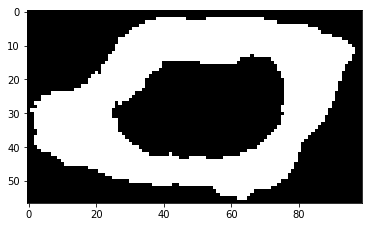

In [2]:
import numpy as np

occupied = np.zeros_like(map_img)
free     = np.zeros_like(map_img)

occupied[p > map_meta['occupied_thresh']] = 1.0
free[p < map_meta['free_thresh']] = 1.0

B = np.argwhere(occupied | free)
(ystart, xstart), (ystop, xstop) = B.min(0), B.max(0) + 1

free_trim = free[ystart:ystop, xstart:xstop]

plt.imshow(free_trim, cmap='gray')
plt.show()

## Step three: identify center line

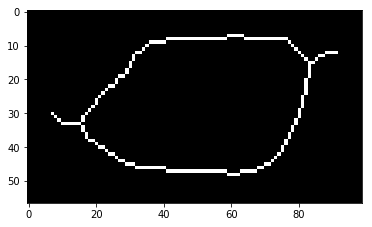

In [3]:
from skimage.morphology import binary_erosion, skeletonize, thin

skeleton = skeletonize(free_trim)

plt.imshow(skeleton, cmap='gray')
plt.show()

## Step four: extract pixels belonging to the closed circuit

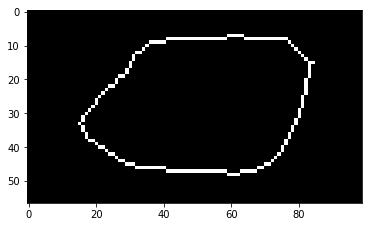

In [4]:
from itertools import permutations

OFFSETS = [-1, 0, 1]
NEIGHBORHOOD = [(dy, dx) for dx in OFFSETS for dy in OFFSETS]

available = np.copy(skeleton).astype(np.bool)

def dfs(point, target, available, path, remaining_steps=15):
    x = point[0]
    y = point[1]
    
    if (remaining_steps == 0) and (point == target).all(): return True
    
    # Lower & upper bounds
    if x < 0 or x >= available.shape[1]: return False
    if y < 0 or y >= available.shape[0]: return False
    
    if not available[y, x]: return False
    
    remaining_steps = max(0, remaining_steps-1)
    
    available[y, x] = False
    path.append(point)
    
    for dx, dy in NEIGHBORHOOD:
        child_x = x + dx
        child_y = y + dy
        
        if dfs((child_x, child_y), target, available, path, remaining_steps):
            return True

    path.pop()
    return False

starting_points = np.transpose(np.nonzero(available))
for starting_point in starting_points:
    path = []
    
    if dfs(starting_point[::-1], starting_point[::-1], available, path):
        break

# TODO Ugly one-time workaround
path = path[::-1]        
    
path_img = np.zeros_like(skeleton)
for point in path:
    path_img[point[1], point[0]] = 1

plt.imshow(path_img, cmap='gray')
plt.show()

## Step five: for each point, find the closest point on the path

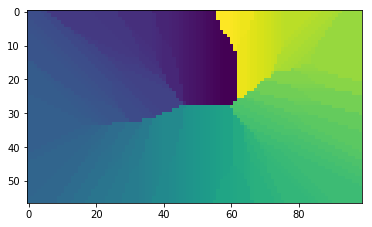

In [5]:
def get_closest_index(y, x):
    point = (x, y)
    
    return np.argmin(np.sum(np.square(np.array(point) - path), 1))

get_closest_indices = np.vectorize(get_closest_index)
closests_img = np.fromfunction(get_closest_indices, skeleton.shape)

plt.imshow(closests_img)
plt.show()

## Step five: calculate path direction

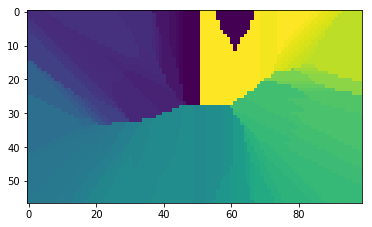

In [6]:
import math

LEN_LOOKAHEAD = int(0.5 / map_meta['resolution'])
directions = []

path_size = len(path)
for i in range(path_size):
    i_front = int(i + LEN_LOOKAHEAD) % path_size
        
    dx = path[i_front][0] - path[i][0]
    dy = path[i_front][1] - path[i][1]
    
    angle = math.atan2(-dy, dx)
    directions.append(angle)

def get_directions(y, x):
    point = (x, y)
    
    closest_point_idx = np.argmin(np.sum(np.square(np.array(point) - path), 1))
    
    return directions[closest_point_idx]

get_directions = np.vectorize(get_directions)
directions_img = np.fromfunction(get_directions, skeleton.shape)

plt.imshow(directions_img)
plt.show()

## Step five: calculate offset from lane center 

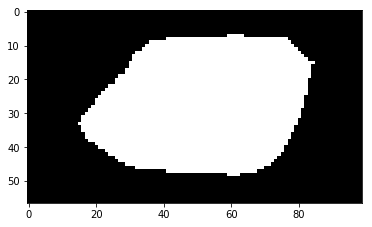

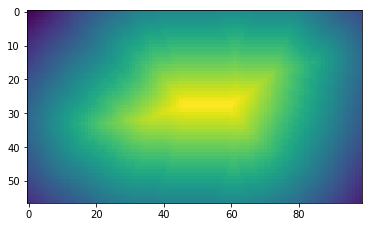

In [7]:
from scipy.ndimage.morphology import binary_fill_holes

interior = np.array(binary_fill_holes(path_img))

plt.imshow(interior, 'gray')
plt.show()

def calc_offset(y, x):
    point = (x, y)
    
    closest_point_idx = np.argmin(np.sum(np.square(np.array(point) - path), 1))
    closest_point = path[closest_point_idx]
    
    dist = np.sqrt((x-closest_point[0])**2 + (y-closest_point[1])**2)
    
    if interior[int(y), int(x)]:
        return dist
    else:
        return -dist

calc_offsets = np.vectorize(calc_offset)

offsets = np.fromfunction(calc_offsets, interior.shape) * map_meta['resolution']

plt.imshow(offsets)
plt.show()

## Calculate road width

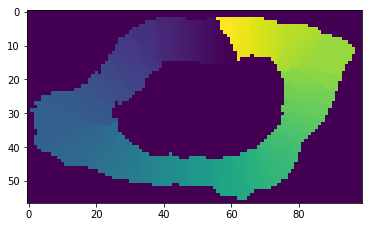

[ 0.76157731  0.7         0.7         0.7         0.7         0.7         0.7
  0.7         0.6         0.6         0.6         0.6         0.6         0.6
  0.6         0.6         0.6         0.67082039  0.58309519  0.7         0.5
  0.6         0.64031242  0.56568542  0.64031242  0.70710678  0.64031242
  0.58309519  0.5         0.63245553  0.63245553  0.58309519  0.64031242
  0.58309519  0.56568542  0.56568542  0.56568542  0.56568542  0.56568542
  0.56568542  0.56568542  0.5         0.67082039  0.78102497  0.70710678
  0.78102497  0.92195445  1.34164079  0.41231056  1.45602198  0.2
  1.34164079  0.4472136   1.11803399  0.98994949  0.56568542  0.5
  0.70710678  0.80622577  0.5         0.58309519  0.63245553  0.5
  0.56568542  0.53851648  0.5         0.2         0.50990195  0.4472136
  0.4         0.4         0.4         0.4         0.5         0.5         0.3
  0.4472136   0.4472136   0.4         0.4         0.4         0.4         0.4
  0.4         0.4         0.4         0.4       

In [8]:
widths = np.zeros_like(directions)

closests_img_masked = (closests_img + 1) * free_trim
plt.imshow(closests_img_masked)
plt.show()

for y, x in np.transpose(np.nonzero(closests_img_masked)):
    path_idx = closests_img[y, x]
    widths[path_idx] = max(widths[path_idx], 2*np.abs(offsets[y, x]))

print(widths)

## Step six: Save results to file

In [9]:
import pickle

data = {}

res = map_meta['resolution']

data['resolution'] = res
data['origin'] = [
    map_meta['origin'][0] + xstart * res,
    map_meta['origin'][1] + (map_img.shape[0] - ystop - 1) * res
]

data['directions'] = directions
data['pathpoints'] = [
    (data['origin'][0] + x*res, data['origin'][1] + (closests_img.shape[0] - y - 1)*res)
    for x, y in path
]
data['widths'] = widths

data['closests'] = closests_img
data['offsets'] = offsets

with open(map_name+'.pkl', 'wb') as f:
    pickle.dump(data, f, 2)